# Model trainer

## Hardware setup

In [1]:
import torch
from torch import nn, cuda
import pandas as pd
import numpy as np

In [2]:
ngpu = torch.cuda.device_count()
# number of GPU units
print("Devices:", ngpu)
for i in range(ngpu):
  print("- ", torch.cuda.get_device_name(i))

Devices: 0


## Model example

https://lirnli.wordpress.com/2017/09/01/simple-pytorch-rnn-examples/

https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-rnn-cb6ebc594677

## Load data

In [3]:
source = 'kaggle' # {'drive', 'kaggle'}
retrain = False

In [4]:
# from drive
if source == 'drive':
    from google.colab import drive
    drive.mount('/drive', force_remount=True)
    path = '/drive/My Drive/Colab Notebooks/data/words.csv'
    model_path = '/drive/My Drive/Colab Notebooks/models/word2vec.model'

# from Kaggle
elif source == 'kaggle':
    path = '../input/732a92project/words.csv'
    model_path = '../input/732a92project/word2vec.model'

# nothing chosen
else: raise RuntimeError
  

In [5]:
# read csv from drive
words = pd.read_csv(path, engine='python')
# parse text column
words['text'] = words.text.apply(eval)

print("Loaded data: %d rows" % (words.shape[0]))
print("Attributes:", words.columns.to_list())

Loaded data: 196292 rows
Attributes: ['text', 'label', 'source']


## Train / Load model

https://datamahadev.com/word2vec-implementation-using-python-gensim-and-google-colab/

https://blog.usejournal.com/train-your-first-gan-model-from-scratch-using-pytorch-9b72987fd2c0

https://streamhacker.com/2014/12/29/word2vec-nltk/

In [6]:
from gensim.models import Word2Vec

if retrain: # train and save
  # train model
  word2vec = Word2Vec(words.text, min_count = 1, size = 100, workers = 4)

  # save model
  word2vec.save(model_path)

else: # load
  word2vec = Word2Vec.load(model_path)

# print model
print(word2vec)

Word2Vec(vocab=307967, size=100, alpha=0.025)


## Vectorize texts

Can be later integrated into the model as initial embedding layer.

https://intellipaat.com/community/12732/using-pre-trained-word2vec-with-lstm-for-word-generation

Maximal sentence length: 2832


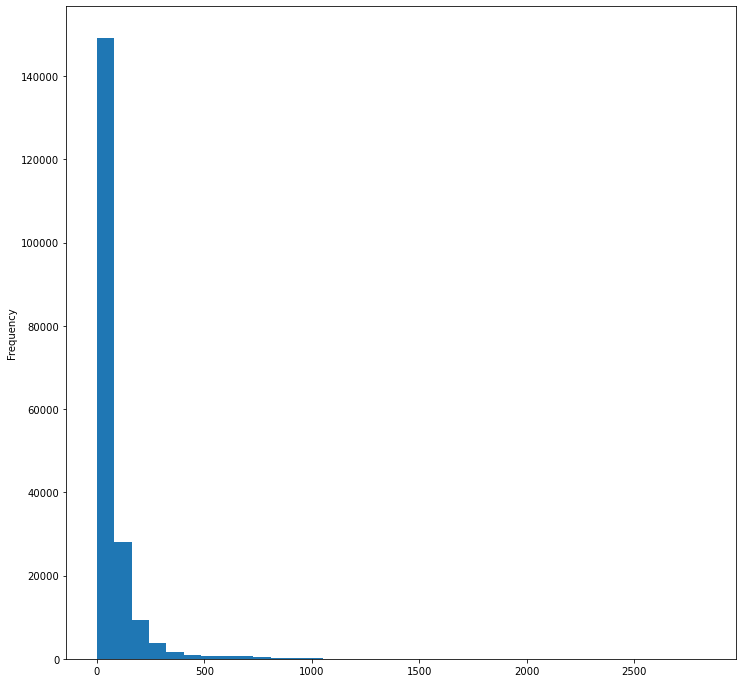

In [7]:
# length of each sentences
K = words.text.apply(len)

# plot ratio
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
pd.Series(K).plot(kind = "hist", bins = 35);

# maximum sentence length
Kmax = K.max()
print("Maximal sentence length:", Kmax)

In [8]:
# drop too long sentences
d1 = words.shape[0]
input_size = 1200
words = words[K <= input_size]\
  .reset_index(drop = True)
d2 = words.shape[0]
"Dropped %d of %d samples (%5.3f %%)." % (d1 - d2, d1, (1 - d2/d1) * 100)

'Dropped 305 of 196292 samples (0.155 %).'

Maximal sentence length: 1200


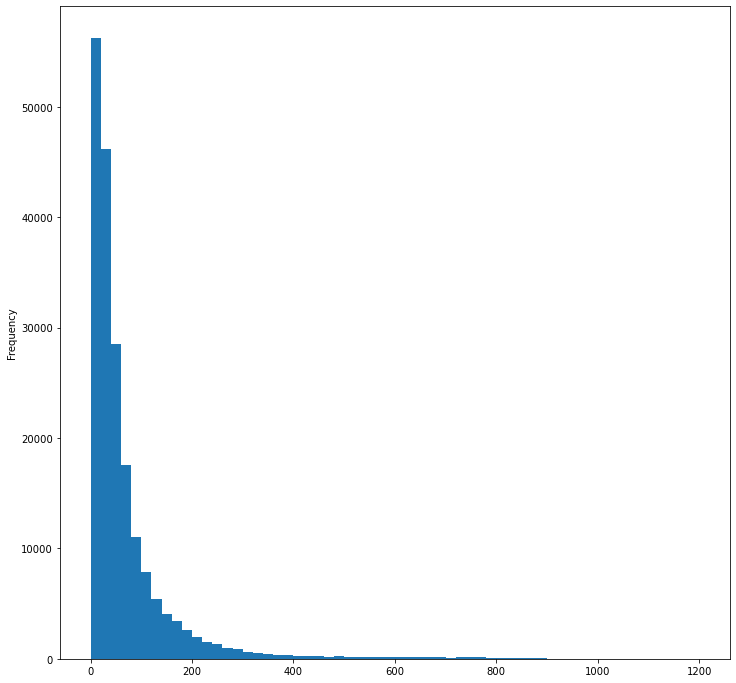

In [9]:
# length of each sentences
K = words.text.apply(len)

# plot ratio
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
pd.Series(K).plot(kind = "hist", bins = 60);

# maximum sentence length
Kmax = K.max()
print("Maximal sentence length:", Kmax)

In [10]:
# dimensions
N    = words.shape[0]
K    = words.text.apply(len).to_numpy()
Kmax = K.max()

# train data
train_y = words.label.to_numpy()
train_x = np.zeros([N, Kmax], dtype=np.int32)
for i,row in words.iterrows():
  for j,word in enumerate(row.text):
    # map words
    train_x[i,j] = word2vec.wv.vocab[word].index

# remove empty lines
nonempty_lines = K > 0
train_x = train_x[nonempty_lines,:]
train_y = train_y[nonempty_lines]
K = K[nonempty_lines]

# result
print("Train data |%d x %d|" % (train_x.shape))
print("Labels |%d x 1|" % (train_y.shape))

# drop original dataframe (save RAM)
del words

Train data |195950 x 1200|
Labels |195950 x 1|


## Model definition

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/402_RNN_classifier.py

### Generator

In [11]:
class Generator(nn.Module):
  """Generator code."""
  def __init__(self, output_size, input_size = 1, hidden_state = 5, num_layers = 1):
    """Generator constructor.
    
    Args:
      ngpu (int): Number of GPUs.
      kfeat (int, optional): Number of features, by default 1.
    """
    super(Generator, self).__init__()
    
    # LSTM layer
    self.lstm = nn.LSTM(input_size,   # input size
                        hidden_state, # hidden size
                        num_layers)   # number of layers

    # linear final layer
    self.linear = nn.Linear(hidden_state, output_size)

  def forward(self, input):
    h1, (hn, cn) = self.lstm(input)
    o  = self.linear(h1)
    return o


In [ ]:
hidden_size = 60
vocab_size = len(word2vec.wv.vocab)
batch_size = 100
num_layers = 2
num_epochs = 1
learning_rate = 0.02

# connect to device
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# instantiate 
model = Generator(vocab_size, 1, #input_size
                  hidden_size, num_layers)#\.to(device)
print(model)

# loss, optimizer
#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# inputs
train_x_torch = torch.from_numpy(train_x.astype(np.float32))
train_y_torch = torch.from_numpy(train_y.astype(np.float32))

# drop original
del train_x
del train_y

print("Input matrix:", train_x_torch.shape)
print("Input targets:", train_y_torch.shape)

batch_1percent = np.ceil(train_x_torch.shape[0] / batch_size) / 100

with torch.no_grad():
    for epoch in range(num_epochs):
        # Set initial hidden and cell states
        #states = (torch.zeros(input_size, hidden_size).to(device),
        #          torch.zeros(hidden_size, hidden_size).to(device))
    
        for it,i in enumerate(range(0, train_x_torch.shape[0], batch_size)):
            # get input
            #input_vector = train_x_torch[i,:K[i]]#.view(1, 1, input_size)
            #input_target = train_y_torch[i]#.view(1, 1)#.reshape((-1,input_size))
            #train_x_input = train_x[i,:K[i]].astype(np.float32)
            #train_y_input = train_y[i].astype(np.float32)
            #print("Input vector:", train_x_input.shape)
            #print("Input target:", train_y_input.shape)
            batch_end = min(i + batch_size, train_x_torch.shape[0])
            batch_size_ = batch_end - i
            input_vector = train_x_torch[i:batch_end,:K[i]]\
                .view((batch_size_,K[i],1))#\.to(device)
            input_target = train_y_torch[i:batch_end]\
                .view((batch_size_))#\.to(device)
            #print("Input vector:", input_vector.shape)
            #print("Input target:", input_target.shape)
            #break
            # truncated backpropagation
            #states = [state.detach() for state in states]
            #print(input_vector.shape)
            output = model(input_vector)
            #print("Output:", output.shape)

            # classical
            #loss = loss_fn(output, input_target) # 
            #model.zero_grad()
            #loss.backward()
            # gradient clipping
            #torch.nn.utils.clip_grad_norm(model.parameters(), .5)
            #optimizer.step()

            #del input_vector
            #del input_target
            
            torch.cuda.empty_cache()
    
            #if it % batch_1percent == 0:
            if it % 10 == 0:
                print("\r%5.3f %%%s" % (i / train_x_torch.shape[0] * 100, " "*10), end = "")
            #print(i)
            # add discriminator
        else:
            loss = 42.
            print ('Epoch [{}/{}], Loss: {:.4f}'
                .format(epoch+1, num_epochs, loss.item()))
      
    #for i in range(0, input_tensor.size(1) - timesteps, timesteps):
    #    # Get mini-batch inputs and targets
    #    inputs = input_tensor[:, i:i+timesteps].to(device)
    #    targets = input_tensor[:, (i+1):(i+1)+timesteps].to(device)
        
    #    states = detach(states)
    #    outputs,_ = model(inputs, states)
    #    loss = loss_fn(outputs, targets.reshape(-1))

    #    model.zero_grad()
    #    loss.backward()
        # Perform Gradient Clipping
    #    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    #    optimizer.step()
    
    #else:
    #    print ('Epoch [{}/{}], Loss: {:.4f}'
    #       .format(epoch+1, num_epochs, loss.item()))

Generator(
  (lstm): LSTM(1, 60, num_layers=2)
  (linear): Linear(in_features=60, out_features=307967, bias=True)
)
Input matrix: torch.Size([195950, 1200])
Input targets: torch.Size([195950])


In [ ]:
#def weights_init(m):
#  """Custom weights initialization called on netG and netD."""
#  classname = m.__class__.__name__
#  if classname.find('Conv') != -1:
#    nn.init.normal_(m.weight.data, 0.0, 0.02)
#  elif classname.find('BatchNorm') != -1:
#    nn.init.normal_(m.weight.data, 1.0, 0.02)
#    nn.init.constant_(m.bias.data, 0)

#class Generator(nn.Module):
#  """Generator code."""
#  def __init__(self, ngpu):
#    super(Generator, self).__init__()
    
    # Number of GPUs available. Use 0 for CPU mode.
#    self.ngpu = ngpu
    # Batch size during training
#    self.batch_size = 128
    # Spatial size of training images. All images will be resized to this
    #   size using a transformer.
#    self.image_size = 64
    # Number of channels in the training images. For color images this is 3
#    self.nc = 3
    # Size of z latent vector (i.e. size of generator input)
#    self.nz = 100
    # Size of feature maps in generator
#    self.ngf = 64
    # Size of feature maps in discriminator
#    self.ndf = 64
    # Number of training epochs
#    self.num_epochs = 5
    # Beta1 hyperparam for Adam optimizers
#    self.beta1 = 0.5

#    self.main = nn.Sequential(
      # input is Z, going into a convolution
#      nn.ConvTranspose2d( self.nz, self.ngf * 8, 4, 1, 0, bias=False),
#      nn.BatchNorm2d(self.ngf * 8),
#      nn.ReLU(True),
      # state size. (ngf*8) x 4 x 4
#      nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
#      nn.BatchNorm2d(self.ngf * 4),
#      nn.ReLU(True),
      # state size. (ngf*4) x 8 x 8
#      nn.ConvTranspose2d( self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
#      nn.BatchNorm2d(self.ngf * 2),
#      nn.ReLU(True),
      # state size. (ngf*2) x 16 x 16
#      nn.ConvTranspose2d( self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
#      nn.BatchNorm2d(self.ngf),
#      nn.ReLU(True),
      # state size. (ngf) x 32 x 32
#      nn.ConvTranspose2d( self.ngf, self.nc, 4, 2, 1, bias=False),
#      nn.Tanh()
      # state size. (nc) x 64 x 64
#    )

#  def forward(self, input):
#    return self.main(input)

# Create the generator
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
#print("Device used:", device)
#netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
#if (device.type == 'cuda') and (ngpu > 1):
#    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netG.apply(weights_init)

# Print the model
#print(netG)

### Discriminator

In [ ]:
#class Discriminator(nn.Module):
#  def __init__(self, ngpu):
#    super(Discriminator, self).__init__()
    # Number of GPUs available. Use 0 for CPU mode.
#    self.ngpu = ngpu
    # Batch size during training
#    self.batch_size = 128
    # Spatial size of training images. All images will be resized to this
    #   size using a transformer.
#    self.image_size = 64
    # Number of channels in the training images. For color images this is 3
#    self.nc = 3
    # Size of z latent vector (i.e. size of generator input)
#   self.nz = 100
    # Size of feature maps in generator
#    self.ngf = 64
    # Size of feature maps in discriminator
#    self.ndf = 64
    # Number of training epochs
#    self.num_epochs = 5
    # Beta1 hyperparam for Adam optimizers
#    self.beta1 = 0.5

#    self.main = nn.Sequential(
      # input is (nc) x 64 x 64
#      nn.Conv2d(self.nc, self.ndf, 4, 2, 1, bias=False),
#      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf) x 32 x 32
#      nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
#      nn.BatchNorm2d(self.ndf * 2),
#      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*2) x 16 x 16
#      nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
#      nn.BatchNorm2d(self.ndf * 4),
#      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*4) x 8 x 8
#      nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
#      nn.BatchNorm2d(self.ndf * 8),
#      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*8) x 4 x 4
#      nn.Conv2d(self.ndf * 8, 1, 4, 1, 0, bias=False),
#      nn.Sigmoid()
#    )

##  def forward(self, input):
#    return self.main(input)

# Create the Discriminator
#netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
#if (device.type == 'cuda') and (ngpu > 1):
#    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netD.apply(weights_init)

# Print the model
#print(netD)

### Optimizer


In [ ]:
# Initialize BCELoss function
#criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
#nz = 100
#fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
#real_label = 1.
#fake_label = 0.

# Setup Adam optimizers for both G and D
#lr = 0.0002 # Learning rate for optimizers
#optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [ ]:
# Training Loop
#num_epochs = 10

# Lists to keep track of progress
#img_list = []
#G_losses = []
#D_losses = []
#iters = 0

#print("Starting Training Loop...")
# For each epoch
#for epoch in range(1,num_epochs+1):
    # For each batch in the dataloader
#    for i, data in enumerate(train_x, 1):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        #netD.zero_grad()
        # Format batch
        #real_cpu = data[0].to(device)
        #b_size = real_cpu.size(0)
        #label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        #output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        #errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        #errD_real.backward()
        #D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        #noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        #fake = netG(noise)
        #label.fill_(fake_label)
        # Classify all fake batch with D
        #output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        #errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        #errD_fake.backward()
        #D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        #errD = errD_real + errD_fake
        # Update D
        #optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        #netG.zero_grad()
        #label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        #errG = criterion(output, label)
        # Calculate gradients for G
        #errG.backward()
        #D_G_z2 = output.mean().item()
        # Update G
        #optimizerG.step()

        # Output training stats
        #if i % 20000 == 0 or i == train_x.shape[0]:
        #    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        #          % (epoch, num_epochs, i, train_x.shape[0],
        #             0, 0, 0, 0, 0))
                     #errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        #G_losses.append(errG.item())
        #D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        #if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        #    with torch.no_grad():
        #        fake = netG(fixed_noise).detach().cpu()
        #    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        #iters += 1